In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Maquina Virtual

In [2]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.6 LTS
Release:	18.04
Codename:	bionic


In [3]:
!lscpu | grep -E '^Model name|^Thread|^Core|^Socket|^CPU\('

CPU(s):              2
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [4]:
!free -m -h

              total        used        free      shared  buff/cache   available
Mem:            12G        823M        9.3G        1.2M        2.6G         11G
Swap:            0B          0B          0B


In [5]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   23G   86G  21% /
tmpfs            64M     0   64M   0% /dev
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.1G  910M  54% /sbin/docker-init
tmpfs           6.4G   32K  6.4G   1% /var/colab
/dev/sda1        41G   24G   17G  59% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive           108G   27G   81G  25% /content/drive


In [6]:
!lsblk -d -o name,rota

NAME  ROTA
loop0    0
sda      0


Instalación de Requerimientos

In [7]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.2/spark-3.2.2-bin-hadoop3.2.tgz
!tar xf spark-3.2.2-bin-hadoop3.2.tgz
!pip -q install findspark

In [8]:
! java -version

openjdk version "11.0.16" 2022-07-19
OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu118.04)
OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu118.04, mixed mode, sharing)


In [9]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.2-bin-hadoop3.2"

In [10]:
!pip -q install pyspark

     |████████████████████████████████| 281.4 MB 43 kB/s 
     |████████████████████████████████| 199 kB 65.7 MB/s 


In [11]:
!pip -q install geopandas attrs shapely rtree apache-sedona[spark]

     |████████████████████████████████| 1.0 MB 7.6 MB/s 
     |████████████████████████████████| 1.0 MB 44.6 MB/s 
     |████████████████████████████████| 67 kB 6.7 MB/s 
     |████████████████████████████████| 16.7 MB 223 kB/s 
     |████████████████████████████████| 6.3 MB 22.5 MB/s 


Descarga de Bases de Datos Listas para el Análisis

In [13]:
#Descarga de Bases de Datos SCINCE 2020 y DENUE Mayo 2022
#!cp /content/drive/MyDrive/SCINCE_Parquets.zip /content
#!cp /content/drive/MyDrive/DENUE_Parquets.zip /content
!gdown 1CbCm0n41uKHPi-L8bTag2G6RA71tdaM4
!gdown 134WppiiO8fdYOxD4yJI-ZX51YTwnVgLu


Downloading...
From: https://drive.google.com/uc?id=1CbCm0n41uKHPi-L8bTag2G6RA71tdaM4
To: /content/DENUE_Parquets.zip
100% 486M/486M [00:02<00:00, 213MB/s]
Downloading...
From: https://drive.google.com/uc?id=134WppiiO8fdYOxD4yJI-ZX51YTwnVgLu
To: /content/SCINCE_Parquets.zip
100% 1.14G/1.14G [00:06<00:00, 173MB/s]


Descompactar los Datos

In [13]:
!ls /content/*.zip

/content/DENUE_Parquets.zip  /content/SCINCE_Parquets.zip


In [14]:
!unzip /content/DENUE_Parquets.zip -d /content/DENUE_Parquets/ &> /dev/null

In [15]:
!unzip /content/SCINCE_Parquets.zip -d /content/SCINCE_Parquets/ &> /dev/null

In [16]:
!ls /content/DENUE_Parquets

01.parquet  07.parquet	13.parquet    18.parquet  24.parquet  30.parquet
02.parquet  08.parquet	14.parquet    19.parquet  25.parquet  31.parquet
03.parquet  09.parquet	15_1.parquet  20.parquet  26.parquet  32.parquet
04.parquet  10.parquet	15_2.parquet  21.parquet  27.parquet
05.parquet  11.parquet	16.parquet    22.parquet  28.parquet
06.parquet  12.parquet	17.parquet    23.parquet  29.parquet


In [17]:
!ls /content

DENUE_Parquets	    sample_data		 spark-3.2.2-bin-hadoop3.2
DENUE_Parquets.zip  SCINCE_Parquets	 spark-3.2.2-bin-hadoop3.2.tgz
drive		    SCINCE_Parquets.zip


Inicio de Apache Spark y Apache Sedona

In [18]:
import findspark
findspark.init()
import shapely
import pandas as pd 
import geopandas as gpd
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import SparkConf
from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
spark = SparkSession. \
builder. \
appName('GeoBigData'). \
config("spark.serializer", KryoSerializer.getName). \
config("spark.executor.memory", "5g"). \
config("spark.driver.memory", "10g"). \
config('spark.driver.maxResultSize', '5g'). \
config("spark.kryo.registrator", SedonaKryoRegistrator.getName). \
config('spark.jars.packages',
           'org.apache.sedona:sedona-python-adapter-3.0_2.12:1.2.0-incubating,'
           'org.datasyslab:geotools-wrapper:1.1.0-25.2'). \
getOrCreate()
SedonaRegistrator.registerAll(spark)

True

Leer Datos

In [98]:
# Cambiar estado
BD_MANZANAS = spark.read.parquet(f"/content/SCINCE_Parquets/19_NL.parquet")
BD_MANZANAS_EEVVV = BD_MANZANAS.select('CVEGEO', 'ECO1_R', 'EDU46_R', 'VIV19_R', 'VIV20_R', 'VIV23_R','VIV82_R',  'VIV82_R', 'VIV83_R', 'VIV84_R', 'geometry')
BD_MANZANAS_EEVVV.cache()
BD_MANZANAS_EEVVV.printSchema()
BD_MANZANAS_EEVVV.show()

root
 |-- CVEGEO: string (nullable = true)
 |-- ECO1_R: double (nullable = true)
 |-- EDU46_R: double (nullable = true)
 |-- VIV19_R: double (nullable = true)
 |-- VIV20_R: double (nullable = true)
 |-- VIV23_R: double (nullable = true)
 |-- VIV82_R: double (nullable = true)
 |-- VIV82_R: double (nullable = true)
 |-- VIV83_R: double (nullable = true)
 |-- VIV84_R: double (nullable = true)
 |-- geometry: geometry (nullable = true)

+----------------+------+-------+-------+-------+-------+-------+-------+-------+-------+--------------------+
|          CVEGEO|ECO1_R|EDU46_R|VIV19_R|VIV20_R|VIV23_R|VIV82_R|VIV82_R|VIV83_R|VIV84_R|            geometry|
+----------------+------+-------+-------+-------+-------+-------+-------+-------+-------+--------------------+
|1900100010021001|  53.7|   10.6|  100.0|  100.0|  100.0|   75.0|   75.0|   30.0|   40.0|POLYGON ((2659352...|
|1900100010021007|  54.5|   12.2|  100.0|  100.0|  100.0|   61.9|   61.9|   19.0|   19.0|POLYGON ((2659829...|
|19001000

In [99]:
BD_MANZANAS_EEVVV.createOrReplaceTempView("manzanas")

In [100]:
BD_MZA_EEVVV_CORREGIDO = spark.sql("""select 
                                  CVEGEO,
                                  if( (isnull(ECO1_R) or ECO1_R < 0 ), 0, ECO1_R) as ECO1_R, 
                                  if( (isnull(EDU46_R) or EDU46_R < 0 ), 0, EDU46_R) as EDU46_R,
                                  if( (isnull(VIV19_R) or VIV19_R < 0 ), 0, VIV19_R) as VIV19_R,
                                  if( (isnull(VIV20_R) or VIV20_R < 0 ), 0, VIV20_R) as VIV20_R,
                                  if( (isnull(VIV23_R) or VIV23_R < 0 ), 0, VIV23_R) as VIV23_R,                    
                                  if( (isnull(VIV82_R) or VIV82_R < 0 ), 0, VIV82_R) as VIV82_R,
                                  if( (isnull(VIV83_R) or VIV83_R < 0 ), 0, VIV83_R) as VIV83_R,
                                  if( (isnull(VIV84_R) or VIV84_R < 0 ), 0, VIV84_R) as VIV84_R,                                  
                                  geometry
                             from manzanas """)

BD_MZA_EEVVV_CORREGIDO.cache()
BD_MZA_EEVVV_CORREGIDO.show()

+----------------+------+-------+-------+-------+-------+-------+-------+-------+--------------------+
|          CVEGEO|ECO1_R|EDU46_R|VIV19_R|VIV20_R|VIV23_R|VIV82_R|VIV83_R|VIV84_R|            geometry|
+----------------+------+-------+-------+-------+-------+-------+-------+-------+--------------------+
|1900100010021001|  53.7|   10.6|  100.0|  100.0|  100.0|   75.0|   30.0|   40.0|POLYGON ((2659352...|
|1900100010021007|  54.5|   12.2|  100.0|  100.0|  100.0|   61.9|   19.0|   19.0|POLYGON ((2659829...|
|1900100010021020|   0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|POLYGON ((2659830...|
|1900100010021037|   0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|POLYGON ((2659506...|
|1900100010021047|  66.7|    0.0|  100.0|  100.0|  100.0|    0.0|    0.0|    0.0|POLYGON ((2659550...|
|1900100010036010|  46.2|    0.0|  100.0|  100.0|  100.0|   55.6|   33.3|    0.0|POLYGON ((2660761...|
|1900100010036012|  43.8|   10.3|  100.0|  100.0|  100.0|   43.8|    0.0|

In [101]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

vecAssembler = VectorAssembler(inputCols=["ECO1_R", "EDU46_R", "VIV19_R", "VIV20_R", "VIV23_R", "VIV82_R", "VIV83_R", "VIV84_R"], outputCol="features")
BD_MZA_EEVVV_CORREGIDO_VEC = vecAssembler.transform(BD_MZA_EEVVV_CORREGIDO)
BD_MZA_EEVVV_CORREGIDO_VEC.cache()
BD_MZA_EEVVV_CORREGIDO_VEC.show()

+----------------+------+-------+-------+-------+-------+-------+-------+-------+--------------------+--------------------+
|          CVEGEO|ECO1_R|EDU46_R|VIV19_R|VIV20_R|VIV23_R|VIV82_R|VIV83_R|VIV84_R|            geometry|            features|
+----------------+------+-------+-------+-------+-------+-------+-------+-------+--------------------+--------------------+
|1900100010021001|  53.7|   10.6|  100.0|  100.0|  100.0|   75.0|   30.0|   40.0|POLYGON ((2659352...|[53.7,10.6,100.0,...|
|1900100010021007|  54.5|   12.2|  100.0|  100.0|  100.0|   61.9|   19.0|   19.0|POLYGON ((2659829...|[54.5,12.2,100.0,...|
|1900100010021020|   0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|POLYGON ((2659830...|           (8,[],[])|
|1900100010021037|   0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|POLYGON ((2659506...|           (8,[],[])|
|1900100010021047|  66.7|    0.0|  100.0|  100.0|  100.0|    0.0|    0.0|    0.0|POLYGON ((2659550...|(8,[0,2,3,4],[66....|
|1900100

In [102]:
kmeans = KMeans(k=5, seed=1, maxIter=250) 
model = kmeans.fit(BD_MZA_EEVVV_CORREGIDO_VEC.select('features'))
transformed = model.transform(BD_MZA_EEVVV_CORREGIDO_VEC)
transformed.show()

+----------------+------+-------+-------+-------+-------+-------+-------+-------+--------------------+--------------------+----------+
|          CVEGEO|ECO1_R|EDU46_R|VIV19_R|VIV20_R|VIV23_R|VIV82_R|VIV83_R|VIV84_R|            geometry|            features|prediction|
+----------------+------+-------+-------+-------+-------+-------+-------+-------+--------------------+--------------------+----------+
|1900100010021001|  53.7|   10.6|  100.0|  100.0|  100.0|   75.0|   30.0|   40.0|POLYGON ((2659352...|[53.7,10.6,100.0,...|         3|
|1900100010021007|  54.5|   12.2|  100.0|  100.0|  100.0|   61.9|   19.0|   19.0|POLYGON ((2659829...|[54.5,12.2,100.0,...|         0|
|1900100010021020|   0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|POLYGON ((2659830...|           (8,[],[])|         1|
|1900100010021037|   0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|    0.0|POLYGON ((2659506...|           (8,[],[])|         1|
|1900100010021047|  66.7|    0.0|  100.0|  100.0|  100.

In [103]:
transformed.createOrReplaceTempView("result_kmeans")
clusters = spark.sql(""" select prediction, 
    mean(ECO1_R) as mean_econ_activa, 
    mean(EDU46_R) as mean_educ_superior,
    mean(VIV82_R) as mean_tv_paga,
    mean(VIV19_R) as agua_entubada,
    mean(VIV20_R) as excusado,
    mean(VIV23_R) as drenaje,
    mean(VIV83_R) as mean_streaming,
    mean(VIV84_R) as mean_videojuegos,
    count(*) as conteo
from result_kmeans group by prediction order by mean_econ_activa""")

clusters.show()

+----------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+--------------------+--------------------+------+
|prediction|  mean_econ_activa| mean_educ_superior|       mean_tv_paga|     agua_entubada|           excusado|            drenaje|      mean_streaming|    mean_videojuegos|conteo|
+----------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+--------------------+--------------------+------+
|         1|0.7070597953866685|0.22977695875961113|0.11575268475567134|0.8087183071741756|0.10438457139226028|0.11675033360869289|0.025023829192349238|0.014653364681959715| 15737|
|         4| 59.33060608532516|  7.918720939717756| 12.082861571090683| 98.82428419936376|  98.24367403540265|  98.94278489273195|   3.875503711558852|  2.3197161269271542| 12259|
|         3|60.410459684517036|  37.72217182316692| 54.933064789113715| 99.77478843680181|   99.7627

In [104]:
df_clusters = clusters.toPandas()

In [105]:
df_clusters

,prediction,mean_econ_activa,mean_educ_superior,mean_tv_paga,agua_entubada,excusado,drenaje,mean_streaming,mean_videojuegos,conteo
0,1,0.707060,0.229777,0.115753,0.808718,0.104385,0.116750,0.025024,0.014653,15737
1,4,59.330606,7.918721,12.082862,98.824284,98.243674,98.942785,3.875504,2.319716,12259
2,3,60.410460,37.722172,54.933065,99.774788,99.762745,99.754451,38.972636,20.722747,14771
3,0,60.847363,9.923402,50.129185,99.609341,99.187770,99.465351,12.685963,7.299405,24194
4,2,63.404933,75.294409,70.256558,99.620799,99.606438,99.603319,69.442824,40.757405,10034


In [106]:
import numpy as np
import matplotlib.pyplot as plt

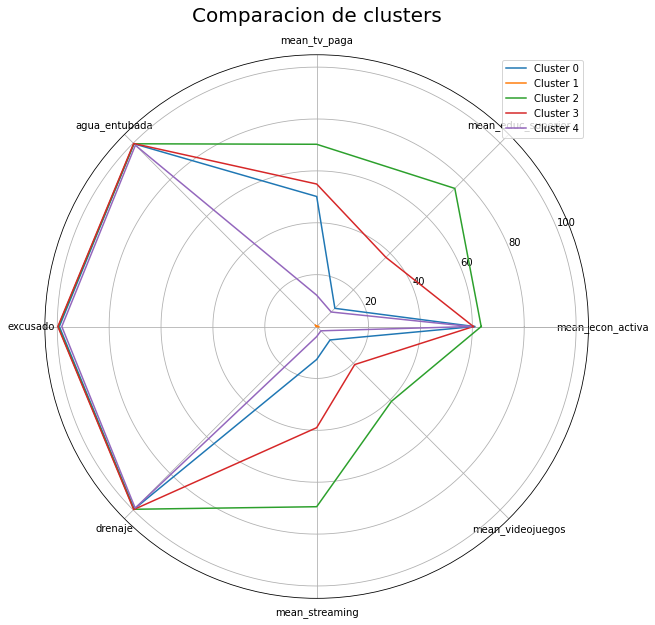

In [107]:
categories = df_clusters.columns[1:-1].values
cluster_0 = df_clusters.where(df_clusters.prediction==0).dropna().values[0][1:-1]
cluster_1 = df_clusters.where(df_clusters.prediction==1).dropna().values[0][1:-1]
cluster_2 = df_clusters.where(df_clusters.prediction==2).dropna().values[0][1:-1]
cluster_3 = df_clusters.where(df_clusters.prediction==3).dropna().values[0][1:-1]
cluster_4 = df_clusters.where(df_clusters.prediction==4).dropna().values[0][1:-1]

cluster_0 = [*cluster_0,cluster_0[0]]
cluster_1 = [*cluster_1,cluster_1[0]]
cluster_2 = [*cluster_2,cluster_2[0]]
cluster_3 = [*cluster_3,cluster_3[0]]
cluster_4 = [*cluster_4,cluster_4[0]]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(cluster_0))

plt.figure(figsize=(10, 10))
plt.subplot(polar=True)
plt.plot(label_loc, cluster_0, label='Cluster 0')
plt.plot(label_loc, cluster_1, label='Cluster 1')
plt.plot(label_loc, cluster_2, label='Cluster 2')
plt.plot(label_loc, cluster_3, label='Cluster 3')
plt.plot(label_loc, cluster_4, label='Cluster 4')
plt.title('Comparacion de clusters', size=20)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

FIN.